In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import os

# Modeling & evaluation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures


# Diagnostics & plots
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, permutation_importance




In [2]:
os.chdir("C:/Users/alber/OneDrive/Desktop/PhD DS Courses/Predictive Analysis")

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
target_col = "Rings" if "Rings" in train.columns else "Target"
X = train.drop(columns=[target_col])
y = train[target_col].values.ravel()

In [5]:
# Identify column types
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()


In [6]:
target="Rings"

In [7]:
# Separate features/target
X = train.drop(columns=[target])
y = train[target]

In [8]:
# ---------------
# 1) Preprocessors
# ---------------
numeric_processor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_processor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_processor, num_cols),
    ("cat", categorical_processor, cat_cols)
])


In [9]:
# ---------------
# 2) Model A: Nonlinear basis expansion + ElasticNet
# ---------------
poly_deg = 2  # quadratic features
model_a = Pipeline(steps=[
    ("prep", preprocess),
    ("poly", PolynomialFeatures(degree=poly_deg, include_bias=False, interaction_only=False)),
    ("reg", ElasticNet(alpha=0.01, l1_ratio=0.2, random_state=42, max_iter=20000))
])


In [10]:
# ---------------
# 3) Model B: Histogram Gradient Boosting (nonlinear trees + boosting)
# ---------------
model_b = Pipeline(steps=[
    ("prep", preprocess),
    ("gbrt", HistGradientBoostingRegressor(
        max_leaf_nodes=31,
        learning_rate=0.05,
        min_samples_leaf=20,
        random_state=42
    ))
])

In [11]:
# ---------------
# 4) Cross-validated RMSE for both models
# ---------------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp))  # negative for sklearn's maximization

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_a = cross_val_score(model_a, X, y, scoring=rmse_scorer, cv=cv, n_jobs=-1)
scores_b = cross_val_score(model_b, X, y, scoring=rmse_scorer, cv=cv, n_jobs=-1)

cv_df = pd.DataFrame({
    "Fold": np.arange(1, len(scores_a)+1),
    "RMSE_Model_A_Poly+ElasticNet": -scores_a,
    "RMSE_Model_B_HistGB": -scores_b
})
cv_df["RMSE_Diff_B_minus_A"] = cv_df["RMSE_Model_B_HistGB"] - cv_df["RMSE_Model_A_Poly+ElasticNet"]

print("Cross-validated RMSE (5-fold):")
print(cv_df)
cv_df.to_csv("cv_rmse_results.csv", index=False)



Cross-validated RMSE (5-fold):
   Fold  RMSE_Model_A_Poly+ElasticNet  RMSE_Model_B_HistGB  \
0     1                      1.962992             1.890313   
1     2                      1.922278             1.852493   
2     3                      1.940721             1.869152   
3     4                      1.922483             1.858755   
4     5                      1.895006             1.830516   

   RMSE_Diff_B_minus_A  
0            -0.072680  
1            -0.069785  
2            -0.071569  
3            -0.063728  
4            -0.064490  


In [12]:
# ---------------
# 5) Fit models on full training set
# ---------------
model_a.fit(X, y)
model_b.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Whole weight.1',
                                                   'Whole weight.2',
                                                   'Shell weight']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex'])])),
                ('gbrt',
                 HistGradientBoostingRegressor(learning_rate=0.05,
                                               random_state=42))])

In [13]:
# ---------------
# 6) Diagnostics on training data: residuals & heteroskedasticity check (simple)
# ---------------
def residual_plots(pipeline, X, y, title_prefix="Model"):
    yhat = pipeline.predict(X)
    resid = y - yhat
    # Residual vs fitted
    plt.figure()
    plt.scatter(yhat, resid, s=8)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"{title_prefix}: Residuals vs Fitted")
    plt.show()


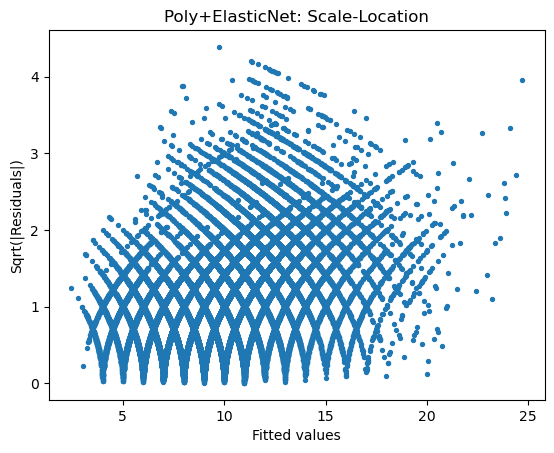

In [15]:
# Scale-location: sqrt(|residuals|) vs fitted
yhat = model_a.predict(X)
resid = y - yhat

plt.figure()
plt.scatter(yhat, np.sqrt(np.abs(resid)), s=8)
plt.xlabel("Fitted values")
plt.ylabel("Sqrt(|Residuals|)")
plt.title("Poly+ElasticNet: Scale-Location")  # replaced title_prefix
plt.show()



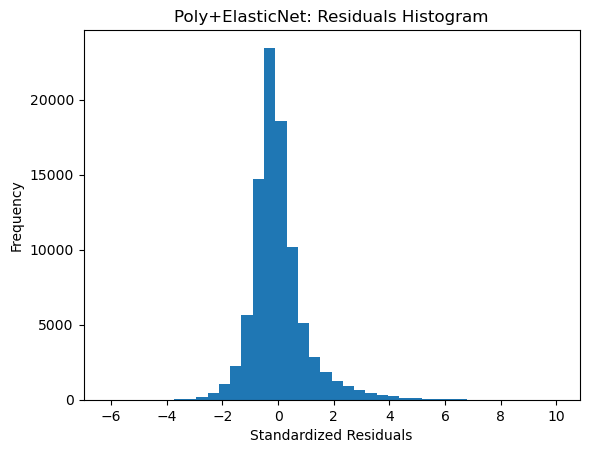

In [19]:
# Residual histogram (proxy for normality)
# Residual histogram (proxy for normality)
std_resid = (resid - np.mean(resid)) / (np.std(resid) + 1e-9)
plt.figure()
plt.hist(std_resid, bins=40)
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency")
plt.title("Poly+ElasticNet: Residuals Histogram")  # replace title_prefix
plt.show()


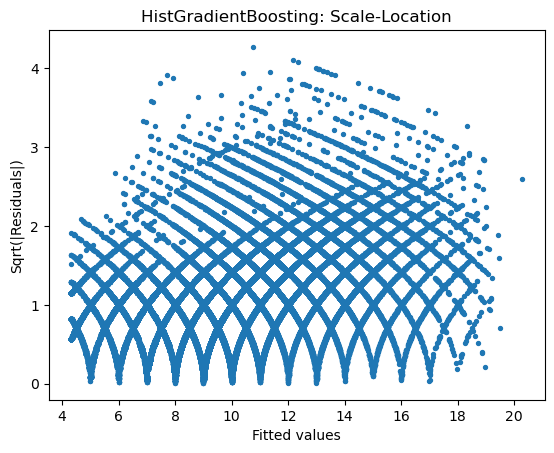

In [17]:
yhat = model_b.predict(X)
resid = y - yhat

plt.figure()
plt.scatter(yhat, np.sqrt(np.abs(resid)), s=8)
plt.xlabel("Fitted values")
plt.ylabel("Sqrt(|Residuals|)")
plt.title("HistGradientBoosting: Scale-Location")
plt.show()


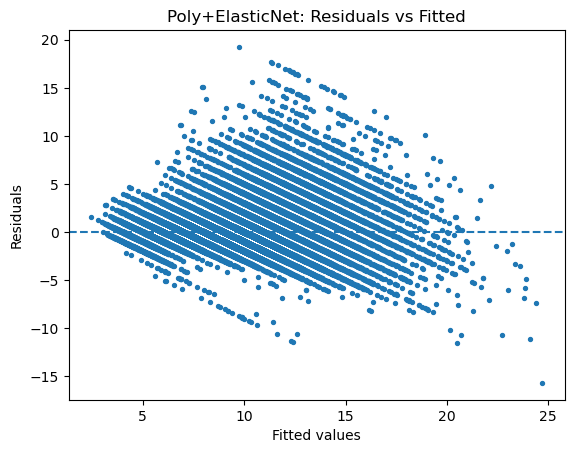

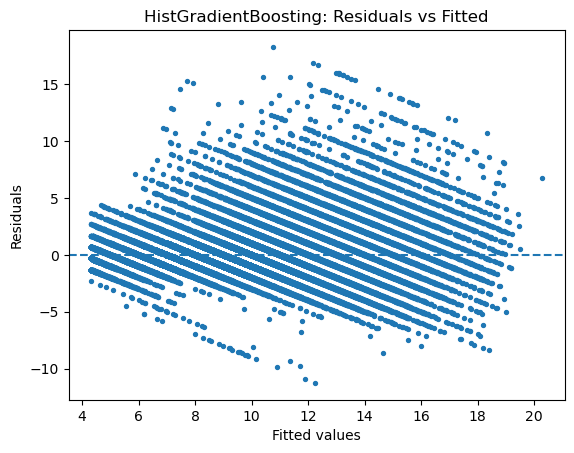

In [18]:
# Generate diagnostics
residual_plots(model_a, X, y, "Poly+ElasticNet")
residual_plots(model_b, X, y, "HistGradientBoosting")


In [20]:
# ---------------
# 7) Interpretability
# ---------------

# Get feature names after preprocessing
ohe = model_b.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = []
if len(cat_cols) > 0:
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
num_feature_names = num_cols
prepped_feature_names = num_feature_names + cat_feature_names


In [21]:
# For Model A: polynomial feature names
poly = model_a.named_steps["poly"]
poly_feature_names = list(poly.get_feature_names_out(prepped_feature_names))

In [22]:
# Coefficients DataFrame (ElasticNet shrinks many to 0)
coef = model_a.named_steps["reg"].coef_
coef_df = pd.DataFrame({
    "feature": poly_feature_names,
    "coef": coef
}).sort_values(by="coef", key=lambda s: np.abs(s), ascending=False).head(40)
print("Top 40 Coefficients (Poly+ElasticNet):")
print(coef_df)
coef_df.to_csv("top40_polyelasticnet_coefficients.csv", index=False)

Top 40 Coefficients (Poly+ElasticNet):
                          feature      coef
7                    Shell weight  2.433565
5                  Whole weight.1 -2.103986
4                    Whole weight  1.231510
61           Whole weight.1 Sex_M -0.929470
59           Whole weight.1 Sex_F -0.844670
68             Shell weight Sex_F  0.821063
70             Shell weight Sex_M  0.774271
56               Whole weight.1^2  0.767124
1                          Length -0.642831
3                          Height  0.552984
58    Whole weight.1 Shell weight -0.524403
63    Whole weight.2 Shell weight -0.498428
43          Height Whole weight.1 -0.467089
45            Height Shell weight  0.456893
37          Diameter Shell weight  0.353716
69             Shell weight Sex_I  0.342053
55             Whole weight Sex_M  0.260787
53             Whole weight Sex_F  0.256003
29                   Length Sex_F -0.221083
54             Whole weight Sex_I  0.214124
74                        Sex_I^2 -0.

In [23]:
# Model B: permutation importance (raw columns)
# Split & fit
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model_b.fit(X_tr, y_tr)

# Permutation importance on the PIPELINE -> uses RAW columns of X_val
r = permutation_importance(model_b, X_val, y_val, n_repeats=5, random_state=42, n_jobs=-1)

# Label with raw feature names
feature_names_raw = X_val.columns.to_list()
assert len(feature_names_raw) == r.importances_mean.shape[0], "name/length mismatch"

imp_df = (
    pd.DataFrame({
        "feature": feature_names_raw,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    })
    .sort_values("importance_mean", ascending=False)
    .head(30)
)

print("Top 30 Permutation Importances (HistGB):")
print(imp_df)
imp_df.to_csv("top30_histgb_importances.csv", index=False)


Top 30 Permutation Importances (HistGB):
          feature  importance_mean  importance_std
8    Shell weight         1.429856        0.015330
6  Whole weight.1         0.677173        0.005386
5    Whole weight         0.090463        0.002012
4          Height         0.056683        0.001187
2          Length         0.021431        0.001327
7  Whole weight.2         0.019511        0.001193
1             Sex         0.014554        0.000560
3        Diameter         0.005739        0.000617
0              id        -0.000059        0.000046


<Figure size 640x480 with 0 Axes>

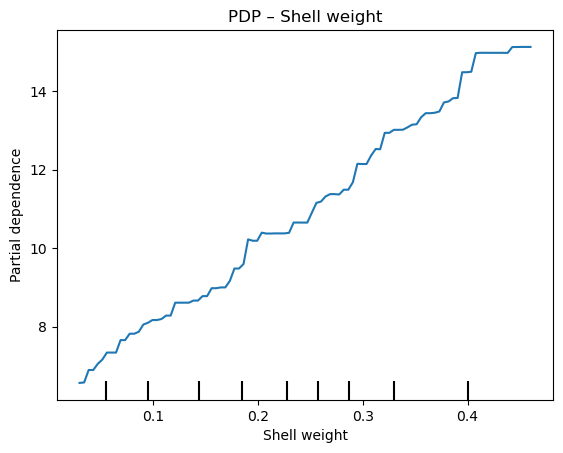

<Figure size 640x480 with 0 Axes>

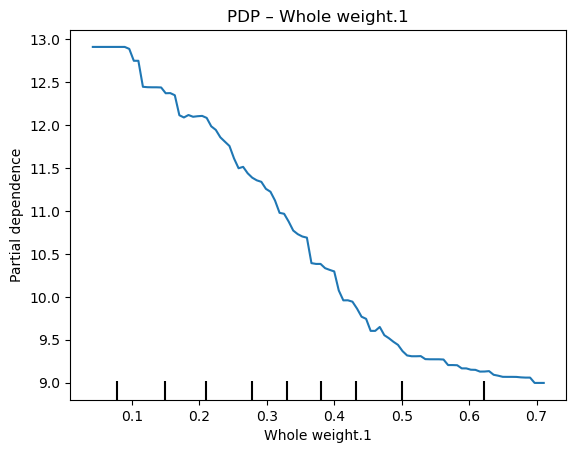

<Figure size 640x480 with 0 Axes>

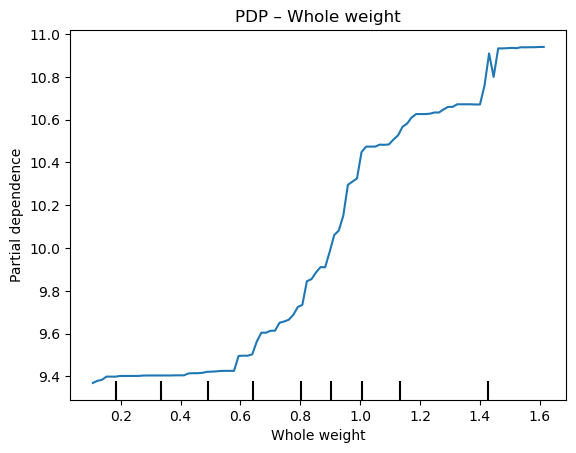

<Figure size 640x480 with 0 Axes>

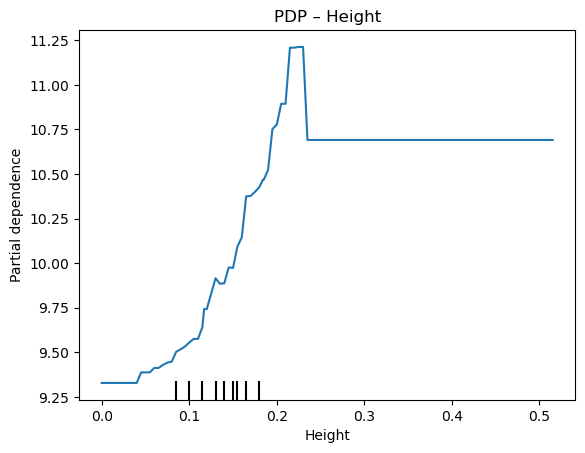

In [24]:
# Partial dependence for top 4 numeric features (if any)
top4 = [f for f in imp_df["feature"].tolist() if f in prepped_feature_names][:4]
if len(top4) > 0:
    for feat in top4:
        fig = plt.figure()
        PartialDependenceDisplay.from_estimator(model_b, X_val, [feat])
        plt.title(f"PDP – {feat}")
        plt.show()


In [25]:
# ---------------
# 8) Create Kaggle-ready submissions from the better model (by mean CV RMSE)
# ---------------
mean_rmse_a = float(np.mean(-scores_a))
mean_rmse_b = float(np.mean(-scores_b))

best_model_name = "HistGradientBoosting" if mean_rmse_b < mean_rmse_a else "PolyElasticNet"
best_model = model_b if best_model_name == "HistGradientBoosting" else model_a

# Fit the chosen model on the full training set
best_model.fit(X, y)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Whole weight.1',
                                                   'Whole weight.2',
                                                   'Shell weight']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex'])])),
                ('gbrt',
                 HistGradientBoostingRegressor(learning_rate=0.05,
                                               random_state=42))])

In [26]:
# Predict the test set
test_pred = best_model.predict(test)

# Build submission
id_col = None
for c in ["Id", "id", "ID"]:
    if c in test.columns:
        id_col = c
        break

if id_col is None:
    submission = pd.DataFrame({
        "Id": np.arange(len(test_pred)),
        "Rings": test_pred
    })
else:
    submission = pd.DataFrame({
        id_col: test[id_col].values,
        "Rings": test_pred
    })

sub_path = Path(f"C:/Users/alber/OneDrive/Desktop/PhD DS Courses/Predictive Analysis{best_model_name}_submission.csv")
submission.to_csv(sub_path, index=False)


In [27]:
# Also save both model submissions for comparison
# Model A
model_a.fit(X, y)
pred_a = model_a.predict(test)
sub_a = pd.DataFrame({"Id": np.arange(len(pred_a)) if id_col is None else test[id_col].values,
                      "Rings": pred_a})
sub_a_path = Path(f"C:/Users/alber/OneDrive/Desktop/PhD DS Courses/Predictive Analysis/abalone_PolyElasticNet_submission.csv")
sub_a.to_csv(sub_a_path, index=False)

In [28]:
# Model B
model_b.fit(X, y)
pred_b = model_b.predict(test)
sub_b = pd.DataFrame({"Id": np.arange(len(pred_b)) if id_col is None else test[id_col].values,
                      "Rings": pred_b})
sub_b_path = Path(f"C:/Users/alber/OneDrive/Desktop/PhD DS Courses/Predictive Analysis//abalone_HistGradientBoosting_submission.csv")
sub_b.to_csv(sub_b_path, index=False)


In [29]:
# Show summary to the user
summary = {
    "cv_summary": {
        "mean_rmse_model_a": mean_rmse_a,
        "mean_rmse_model_b": mean_rmse_b,
        "selected_best_model": best_model_name
    },
    "files": {
        "best_submission": str(sub_path),
        "poly_elasticnet_submission": str(sub_a_path),
        "histgb_submission": str(sub_b_path)
    }
}
summary

{'cv_summary': {'mean_rmse_model_a': 1.9286958944362567,
  'mean_rmse_model_b': 1.860245562991323,
  'selected_best_model': 'HistGradientBoosting'},
 'files': {'best_submission': 'C:\\Users\\alber\\OneDrive\\Desktop\\PhD DS Courses\\Predictive AnalysisHistGradientBoosting_submission.csv',
  'poly_elasticnet_submission': 'C:\\Users\\alber\\OneDrive\\Desktop\\PhD DS Courses\\Predictive Analysis\\abalone_PolyElasticNet_submission.csv',
  'histgb_submission': 'C:\\Users\\alber\\OneDrive\\Desktop\\PhD DS Courses\\Predictive Analysis\\abalone_HistGradientBoosting_submission.csv'}}